<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier


from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
#import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

<h2> Reading the data from train.csv

In [2]:
path = "C:\\Users\\Ruchita Kyada\\Downloads\\Quora\\train.csv"

quora_data = pd.read_csv(path)

print("Number of data points:",quora_data.shape[0])

Number of data points: 404290


In [3]:
quora_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
quora_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [5]:
#https://towardsdatascience.com/speed-up-your-exploratory-data-analysis-with-pandas-profiling-88b33dc53625
import pandas_profiling
pandas_profiling.ProfileReport(quora_data)

<h3> Checking for NULL values </h3>

In [6]:
#Checking whether there are any rows with null values
nan_rows = quora_data[quora_data.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


<div class="alert alert-block alert-info">
<b>Null Values:</b> Three rows contains null values(two null values in question2 and one null value in question1)
</div>

In [7]:
# Filling the null values with ' '
quora_data = quora_data.fillna('')
nan_rows = quora_data[quora_data.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


# **Basic EDA**

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

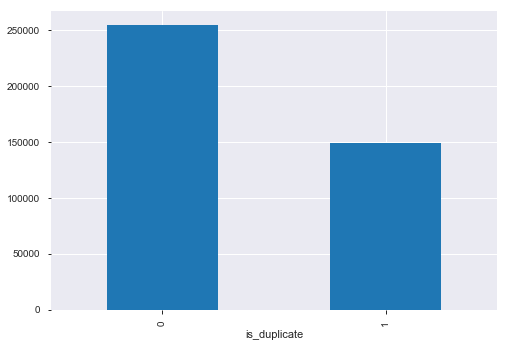

In [8]:
quora_data.groupby("is_duplicate")['id'].count().plot.bar()

In [9]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(quora_data['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(quora_data['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [10]:
qids = pd.Series(quora_data['qid1'].tolist() + quora_data['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



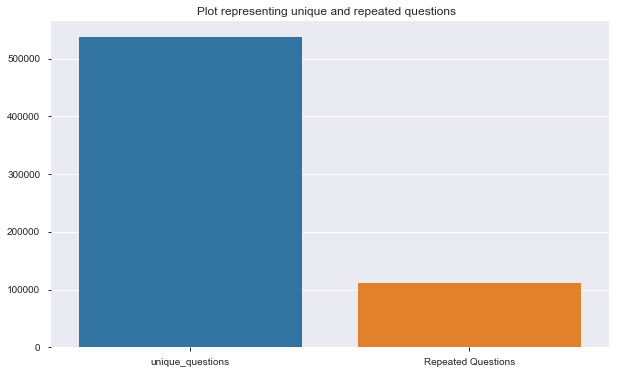

In [11]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

<div class="alert alert-block alert-info">
<b>Duplicates:</b> As we can see in the profiling report there is no duplicates in the dataset
</div>

<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



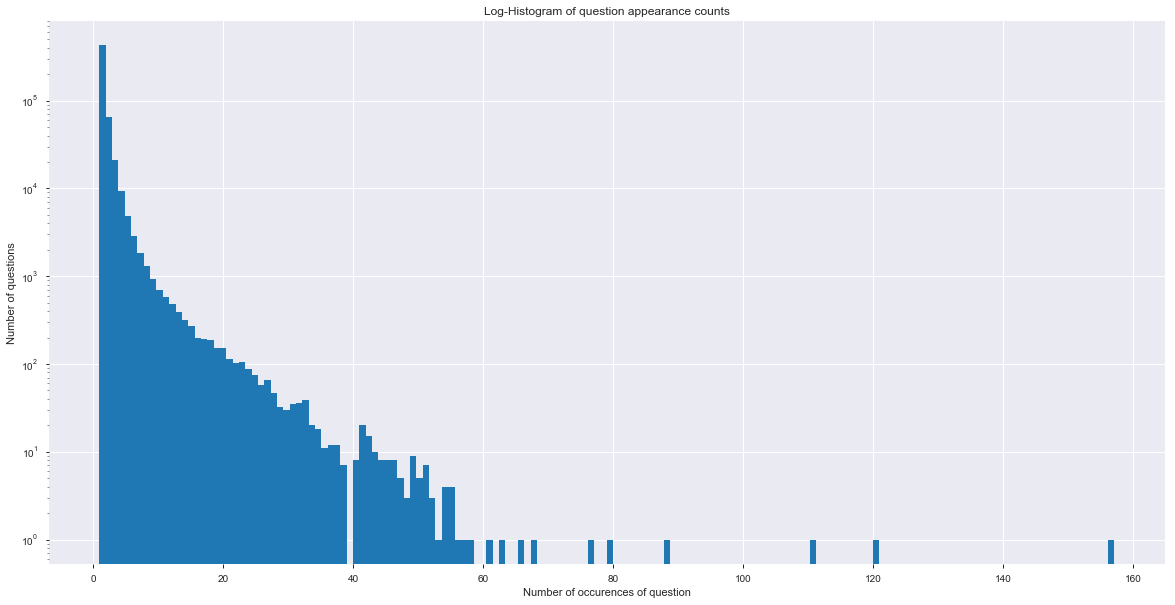

In [12]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<div class="alert alert-block alert-info">
<b>Repeated Questions:</b> There is one question which is repeated 157 times
</div>

<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [13]:

quora_data['freq_qid1'] = quora_data.groupby('qid1')['qid1'].transform('count') 
quora_data['freq_qid2'] = quora_data.groupby('qid2')['qid2'].transform('count')
quora_data['q1len'] = quora_data['question1'].str.len() 
quora_data['q2len'] = quora_data['question2'].str.len()
quora_data['q1_n_words'] = quora_data['question1'].apply(lambda row: len(row.split(" ")))
quora_data['q2_n_words'] = quora_data['question2'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
quora_data['word_Common'] = quora_data.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
quora_data['word_Total'] = quora_data.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
quora_data['word_share'] = quora_data.apply(normalized_word_share, axis=1)

quora_data['freq_q1+q2'] = quora_data['freq_qid1']+quora_data['freq_qid2']
quora_data['freq_q1-q2'] = abs(quora_data['freq_qid1']-quora_data['freq_qid2'])


quora_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [14]:
ques1 = quora_data['question1']
ques2 = quora_data['question2']
print(len(ques1))

404290


#### Sequence Ratio between two questions

In [15]:
#https://stackoverflow.com/questions/43561877/how-do-i-compare-two-sentence-strings-for-a-similarity-in-python
#This idea I got by looking at one the comment from the videos section.Please let me know the way I have done is correct or not
from difflib import SequenceMatcher
sequence_ratio = []
n = len(ques1)
for i in range(n):
  sequence_ratio.append(SequenceMatcher(None, ques1[i], ques2[i]).ratio())

quora_data['sequence_ratio'] = sequence_ratio

In [16]:
quora_data.head(9)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,sequence_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.926829
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3,0.647482
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0,0.454545
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0,0.069565
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2,0.365217
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,1,1,86,90,16,16,8.0,31.0,0.258065,2,0,0.659091
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,1,1,19,62,4,11,0.0,14.0,0.000000,2,0,0.172840
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,1,1,30,41,7,9,4.0,16.0,0.250000,2,0,0.591549
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,1,2,31,37,8,8,6.0,16.0,0.375000,3,1,0.852941


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [17]:
print ("Minimum length of the questions in question1 : " , min(quora_data['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(quora_data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", quora_data[quora_data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", quora_data[quora_data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

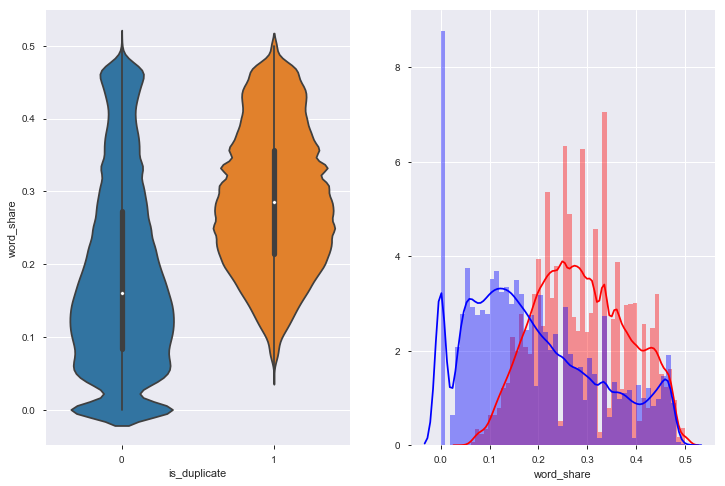

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = quora_data[0:])

plt.subplot(1,2,2)
sns.distplot(quora_data[quora_data['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(quora_data[quora_data['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

<div class="alert alert-block alert-info">
<b>Word_Share:</b>
    <ul>
        <li>The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity</li>
        <li>The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar) </li>
    </ul>
</div> 



<h4> 3.3.1.2 Feature: word_Common </h4>

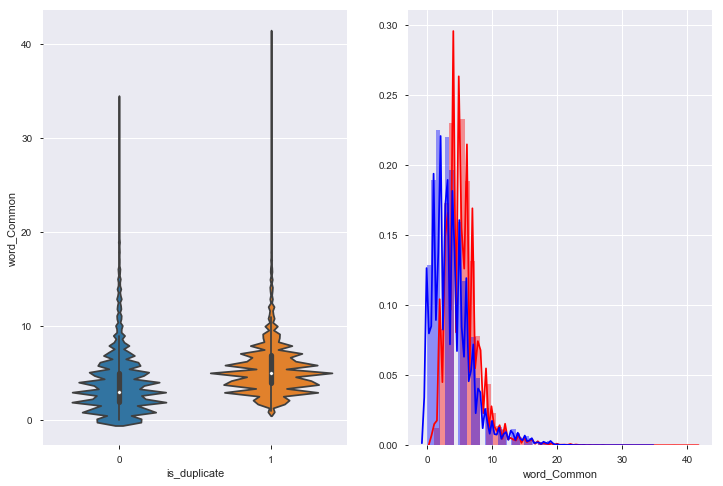

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = quora_data[0:])

plt.subplot(1,2,2)
sns.distplot(quora_data[quora_data['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(quora_data[quora_data['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<div class="alert alert-block alert-warning">
    <b>Word_Common</b>
<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>
</div>


<h4> 3.3.1.2 Feature: sequence_ratio </h4>

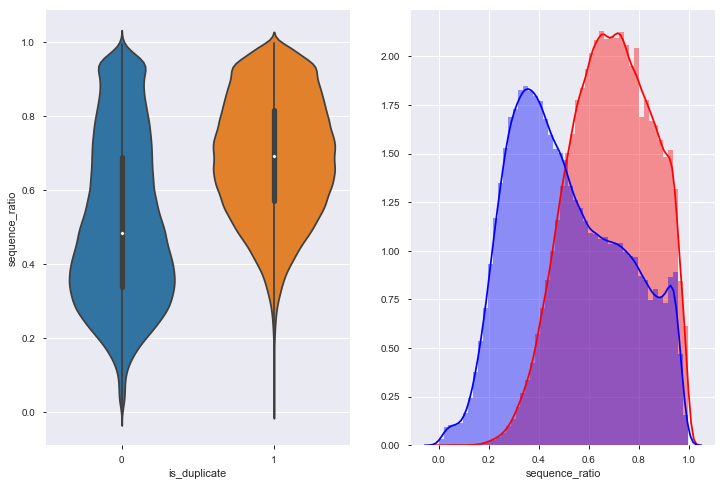

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'sequence_ratio', data = quora_data[0:])

plt.subplot(1,2,2)
sns.distplot(quora_data[quora_data['is_duplicate'] == 1.0]['sequence_ratio'][0:] , label = "1", color = 'red')
sns.distplot(quora_data[quora_data['is_duplicate'] == 0.0]['sequence_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<div class="alert alert-block alert-info">
    <b> Sequence Ratio : </b>
<ul>
    <li> The distributions for sequence ratio between two questions(question1 and question2) have some overlap on the far right-hand side, i.e., there are quite a lot of questions with same sequence</li>
    <li> The sequence ratio is more for duplicate questions in comparsion with non-duplicate questions</li>
    </ul>
</div>


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [21]:
# To get the results in 4 decemal points
import nltk
nltk.download('stopwords')
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to C:\Users\Ruchita
[nltk_data]     Kyada\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [22]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features



def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    
    return df

In [23]:
import _lcsubstrings as lc

In [24]:
# get the Longest Common sub string
#import distance
# from importlib import reload
# reload(distance)
def get_longest_substr_ratio(a, b):
    strs = list(lc.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
quora_data["longest_substr_ratio"]  = quora_data.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)

In [25]:
from nltk.stem import PorterStemmer
#import /content/drive/My Drive/distance
quora_data = extract_features(quora_data)
  
quora_data.head(2)

token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [26]:
df_duplicate = quora_data[quora_data['is_duplicate'] == 1]
dfp_nonduplicate = quora_data[quora_data['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('C:\\Users\\Ruchita Kyada\\Downloads\\Quora\\train_p.txt', p, delimiter=' ', encoding='utf-8' , fmt='%s')
np.savetxt('C:\\Users\\Ruchita Kyada\\Downloads\\Quora\\train_n.txt', n, delimiter=' ', encoding='utf-8', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [27]:
# reading the text files and removing the Stop Words:
#d = path.dirname('.')
#https://stackoverflow.com/questions/27092833/unicodeencodeerror-charmap-codec-cant-encode-characters
textp_w = open('C:\\Users\\Ruchita Kyada\\Downloads\\Quora\\train_p.txt',encoding='utf-8').read()
textn_w = open('C:\\Users\\Ruchita Kyada\\Downloads\\Quora\\train_n.txt',encoding='utf-8').read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


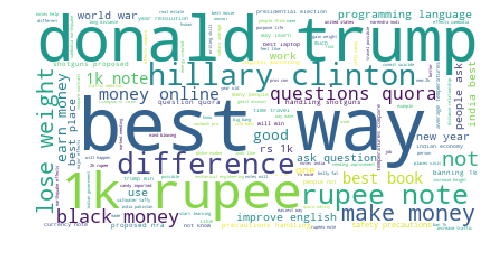

In [28]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc)
plt.axis("off")
plt.show()

<div class="alert alert-block alert-info">
 Words like <font color='red'> best way , donald trump,1k rupee and difference </font> are mostly observed in Duplicate Question
</div>


__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


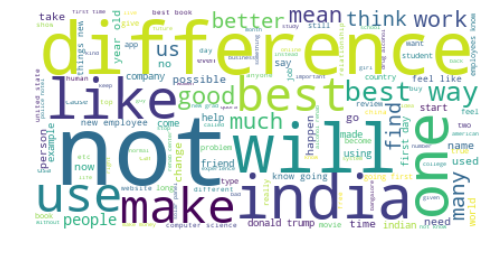

In [29]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<div class="alert alert-block alert-info">
    <p>Word like <font color="red">like,india,will,not,one,difference and one</font> are found more in duplicate questions</p>
</div>

<div class="alert alert-block alert-info">
<b>WordCloud:</b>
    <ul>
        <li>Here we can observe that some words like <font color="red">difference,best way etc</font> are found in both duplicate and non-duplicate questions</li>
        <li>There is frequency difference between the common words,this can be observed by the size difference of common words</li>
    </ul>
</div>

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

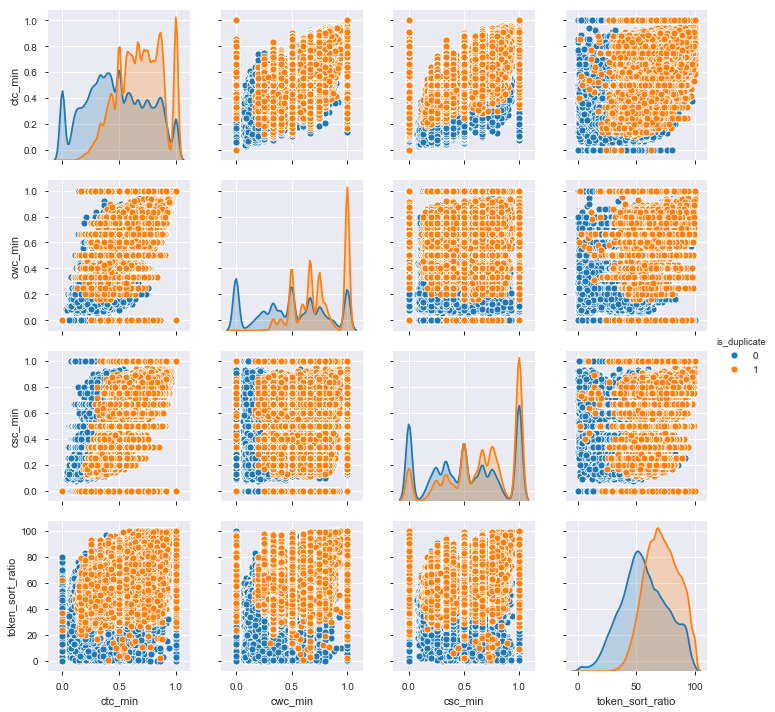

In [30]:
n = quora_data.shape[0]
sns.pairplot(quora_data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

<div class="alert alert-block alert-info">
<b>PairPlot:</b>
    <p>We can observe from <font color="black">token_sort_ratio vs ctc_min/cwc_min/csc_min </font> plot that these features are important as we are able to get some seperability between duplicate and non-duplicate question</p>
</div>

#### feature: token_sort_ratio

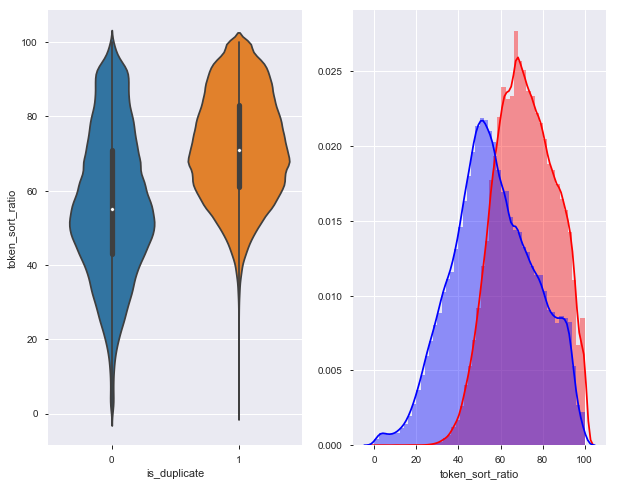

In [31]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = quora_data[0:] , )

plt.subplot(1,2,2)
sns.distplot(quora_data[quora_data['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(quora_data[quora_data['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<div class="alert alert-block alert-info">
<b>Token_Sort_ratio:</b>
    <ul><li>There is overlap between duplicate and non-duplicate questions for token_sort_ratio.</li>
        <li>Token_sort_ratio is more for duplicate question than non-duplicate questions</li>
    </ul>
</div>

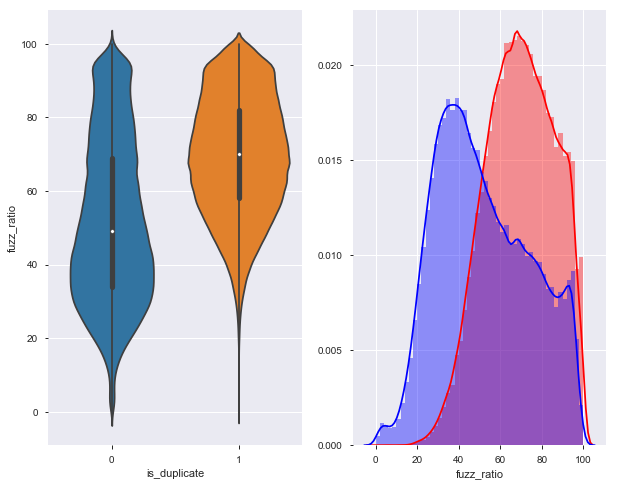

In [32]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = quora_data[0:] , )

plt.subplot(1,2,2)
sns.distplot(quora_data[quora_data['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(quora_data[quora_data['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<div class="alert alert-block alert-info">
<b>Token_Sort_ratio:</b>
    <ul><li>There is overlap between duplicate and non-duplicate questions for fuzz_ratio.The probability of non-duplicate questions is high when the fuzz_ratio is more</li>
        <li>fuzz_ratio is more for duplicate question than non-duplicate questions</li>
    </ul>
</div>

<h3>3.5.2 Visualization </h3>

In [33]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = quora_data[0:8000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [34]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.152s...
[t-SNE] Computed neighbors for 8000 samples in 0.726s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.104039
[t-SNE] Computed conditional probabilities in 0.385s
[t-SNE] Iteration 50: error = 90.1075897, gradient norm = 0.0347355 (50 iterations in 4.472s)
[t-SNE] Iteration 100: error = 74.8392715, gradient norm = 0.0058055 (50 iterations in 3.246s)
[t-SNE] Iteration 150: error = 72.2730560, gradient norm = 0

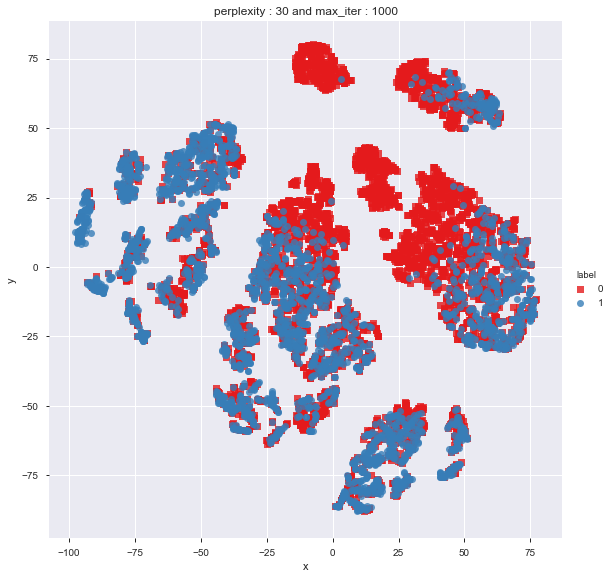

In [35]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [36]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.024s...
[t-SNE] Computed neighbors for 8000 samples in 0.722s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.104039
[t-SNE] Computed conditional probabilities in 0.314s
[t-SNE] Iteration 50: error = 91.4485931, gradient norm = 0.0238583 (50 iterations in 18.869s)
[t-SNE] Iteration 100: error = 73.1852798, gradient norm = 0.0022852 (50 iterations in 11.236s)
[t-SNE] Iteration 150: error = 71.1063232, gradient norm =

In [37]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf word-vectors </h2>

In [38]:
quora_data.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,4,1,51,88,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75


In [39]:
y_true = quora_data['is_duplicate']
quora_data.drop(['is_duplicate','id','qid1','qid2'], axis=1, inplace=True)
quora_data.head(2)

,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,1,1,66,57,14,12,10.0,23.0,...,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100
1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,4,1,51,88,8,13,4.0,20.0,...,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75


In [40]:
X_train,X_test, y_train, y_test = train_test_split(quora_data, y_true, stratify=y_true, test_size=0.3)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
train_questions = list(X_train['question1']) + list(X_train['question2'])


tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(train_questions)

X_train_q1 = tfidf.transform(X_train['question1'].values)
X_train_q2 = tfidf.transform(X_train['question2'].values)
X_test_q1 = tfidf.transform(X_test['question1'].values)
X_test_q2 = tfidf.transform(X_test['question2'].values)

# dict key:word and value:tf-idf score
#word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [42]:
print(X_train_q1.shape)
print(X_train_q2.shape)
print(X_test_q1.shape)
print(X_test_q2.shape)

(283003, 73970)
(283003, 73970)
(121287, 73970)
(121287, 73970)


In [43]:
train_q1_q2 = hstack((X_train_q1,X_train_q2))

In [44]:
type(train_q1_q2)

scipy.sparse.coo.coo_matrix

In [45]:
X_train.drop(['question1','question2'],axis=1,inplace=True)

In [46]:
X_train_final = hstack((X_train,train_q1_q2),format='csr',dtype='float64')

In [47]:
print(X_train_final.shape)

(283003, 147967)


In [48]:
test_q1_q2 = hstack((X_test_q1,X_test_q2))
X_test.drop(['question1','question2'],axis=1,inplace=True)
X_test_final = hstack((X_test,test_q1_q2),format='csr',dtype='float64')
print(X_test_final.shape)

(121287, 147967)


In [49]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8848680744295501


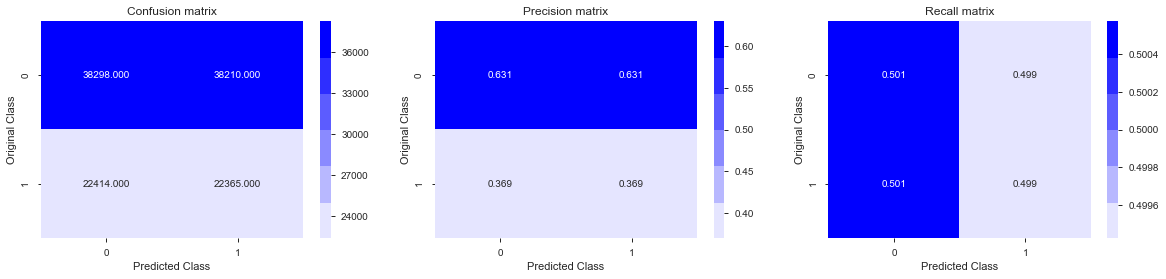

In [50]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
test_len = len(y_test)
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<div class="alert alert-block alert-danger">
<b>Random Model:</b>
From Confusion Matrix, Precision Matrix and Recall Matrix we can see that model is performing worst with test accuracy of 0.88.
</div>

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.43943250576029824
For values of alpha =  0.0001 The log loss is: 0.4410097038282857
For values of alpha =  0.001 The log loss is: 0.4397823497671408
For values of alpha =  0.01 The log loss is: 0.4431094015140632
For values of alpha =  0.1 The log loss is: 0.4565947583252657
For values of alpha =  1 The log loss is: 0.48452106086253355
For values of alpha =  10 The log loss is: 0.5286384743225593


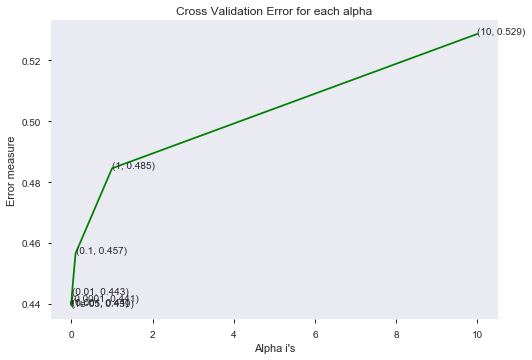

For values of best alpha =  1e-05 The train log loss is: 0.4414301373087021
For values of best alpha =  1e-05 The test log loss is: 0.43943250576029824
Total number of data points : 121287


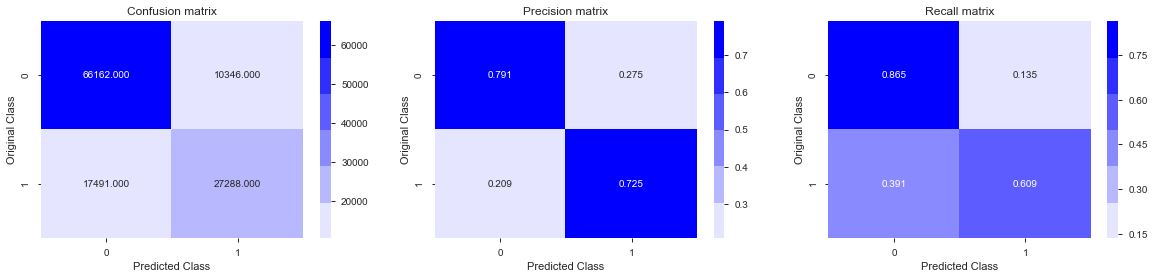

In [51]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight='balanced')
    clf.fit(X_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train)
    predict_y = sig_clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(X_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4400314354160637
For values of alpha =  0.0001 The log loss is: 0.4767371603718364
For values of alpha =  0.001 The log loss is: 0.49985632859852025
For values of alpha =  0.01 The log loss is: 0.5086144549477059
For values of alpha =  0.1 The log loss is: 0.489865613205001
For values of alpha =  1 The log loss is: 0.5632255331265493
For values of alpha =  10 The log loss is: 0.5861198597090167


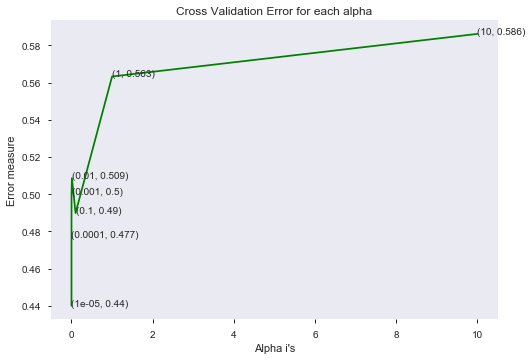

For values of best alpha =  1e-05 The train log loss is: 0.4426646315996417
For values of best alpha =  1e-05 The test log loss is: 0.4400314354160637
Total number of data points : 121287


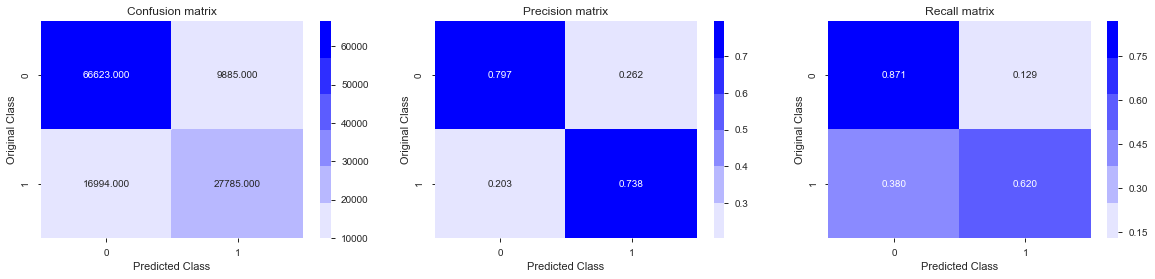

In [52]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
    clf.fit(X_train_final, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_final, y_train)
    predict_y = sig_clf.predict_proba(X_test_final)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(X_train_final, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_final, y_train)

predict_y = sig_clf.predict_proba(X_train_final)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_final)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2>4.6 XGBoost</h2>

In [53]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

#https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid = {'n_estimators': [5, 10, 50, 100, 200, 500, 1000],'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],'class_weight':['balanced']}
clf = RandomizedSearchCV(xgb.XGBClassifier(), grid, cv=3, scoring='neg_log_loss',return_train_score=True)
clf.fit(X_train_final, y_train)


test_mean = clf.cv_results_['mean_test_score'] 
test_param = clf.cv_results_['params']

In [54]:
for mean,param in zip(test_mean,test_param):
    print("The mean = ",mean.round(4),"is for params = ",param)
    
print("Best score is",clf.best_score_,"with params = ",clf.best_params_)

The mean =  -0.5792 is for params =  {'n_estimators': 5, 'max_depth': 2, 'class_weight': 'balanced'}
The mean =  -0.3689 is for params =  {'n_estimators': 50, 'max_depth': 4, 'class_weight': 'balanced'}
The mean =  -0.3496 is for params =  {'n_estimators': 50, 'max_depth': 6, 'class_weight': 'balanced'}
The mean =  -0.3222 is for params =  {'n_estimators': 100, 'max_depth': 9, 'class_weight': 'balanced'}
The mean =  -0.3323 is for params =  {'n_estimators': 1000, 'max_depth': 2, 'class_weight': 'balanced'}
The mean =  -0.4108 is for params =  {'n_estimators': 50, 'max_depth': 2, 'class_weight': 'balanced'}
The mean =  -0.3006 is for params =  {'n_estimators': 1000, 'max_depth': 8, 'class_weight': 'balanced'}
The mean =  -0.2984 is for params =  {'n_estimators': 1000, 'max_depth': 9, 'class_weight': 'balanced'}
The mean =  -0.5163 is for params =  {'n_estimators': 5, 'max_depth': 10, 'class_weight': 'balanced'}
The mean =  -0.3299 is for params =  {'n_estimators': 200, 'max_depth': 5, '

In [55]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 10
params['class_weight'] = 'balanced'
params['n_estimators'] = 100

d_train = xgb.DMatrix(X_train_final, label=y_train)
d_test = xgb.DMatrix(X_test_final, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist,verbose_eval=10)

xgdmat = xgb.DMatrix(X_train_final,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.682076	valid-logloss:0.682605
[10]	train-logloss:0.596094	valid-logloss:0.597992
[20]	train-logloss:0.533984	valid-logloss:0.537877
[30]	train-logloss:0.488257	valid-logloss:0.493651
[40]	train-logloss:0.453233	valid-logloss:0.460211
[50]	train-logloss:0.4255	valid-logloss:0.434329
[60]	train-logloss:0.40374	valid-logloss:0.414009
[70]	train-logloss:0.38662	valid-logloss:0.397843
[80]	train-logloss:0.372203	valid-logloss:0.385143
[90]	train-logloss:0.360633	valid-logloss:0.374789
[100]	train-logloss:0.350827	valid-logloss:0.366072
[110]	train-logloss:0.342581	valid-logloss:0.359007
[120]	train-logloss:0.336019	valid-logloss:0.353315
[130]	train-logloss:0.330386	valid-logloss:0.34859
[140]	train-logloss:0.325538	valid-logloss:0.344758
[150]	train-logloss:0.32115	valid-logloss:0.341446
[160]	train-logloss:0.318108	valid-logloss:0.338832
[170]	train-logloss:0.315063	valid-logloss:0.336595
[180]	train-logloss:0.312973	valid-logloss:0.334662
[190]	train-logloss:0.310912	

Total number of data points : 121287


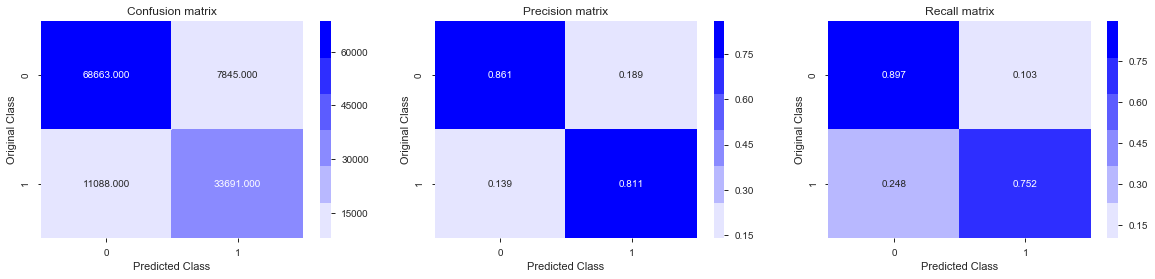

In [56]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [58]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names=['Model','Test Loss']

x.add_row(['Dumb Model',0.8848])
x.add_row(['LogisticRegression',0.4394])
x.add_row(['Linear SVM',0.4400])
x.add_row(['XGBoost',0.3193])

print(x)

+--------------------+-----------+
|       Model        | Test Loss |
+--------------------+-----------+
|     Dumb Model     |   0.8848  |
| LogisticRegression |   0.4394  |
|     Linear SVM     |    0.44   |
|      XGBoost       |   0.3193  |
+--------------------+-----------+


<div class="alert alert-block alert-info">
<b>Conclusion:</b>
    <ul>
        <li>Logistic Regression and Linear SVM have almost same test loss , which shows that both the model performs ssme on this dataset</li>
        <li>Best Model can be taken as XGBoost as it reduces the loss.</li>
        <li>From the recall percentage of class 1(duplicate) and 0(non-duplicate) for XGBoost model, we can say that model is performing quite well without fitting.</li>
</div>